In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 195.5 kB/s eta 0:00:0000:0100:01


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import visualkeras

2024-03-05 13:51:11.013880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 13:51:11.013972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 13:51:11.179667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Load data

In [3]:
image_dir = "/kaggle/input/japanese-characters/Data"

filenames = os.listdir(image_dir)
# lấy tên lớp từ tên file
labels = [x.split(" ")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4753 entries, 0 to 4752
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4753 non-null   object
 1   label     4753 non-null   object
dtypes: object(2)
memory usage: 74.4+ KB


Thống kê số lượng sample trong mỗi lớp

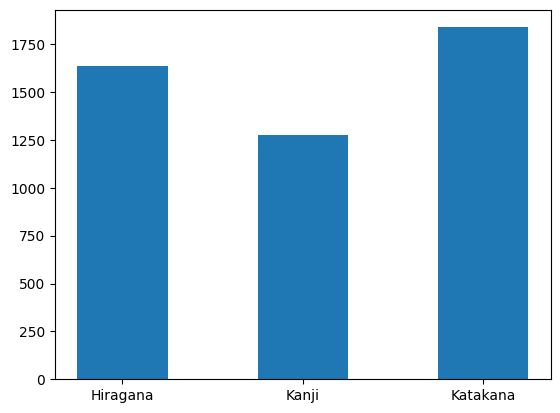

In [5]:
# đếm số lượng sample trong mỗi lớp
samples_per_class = np.unique(data.label, return_counts=True)
# vẽ biểu đồ
plt.bar(samples_per_class[0], samples_per_class[1], width=0.5)
plt.show()

## Chuẩn bị các tập dữ liệu

In [4]:
labels = data['label']

# chia tập dữ liệu thành train set và test set với tỉ lệ là 80% và 20%
X_test, X_train = train_test_split(data, test_size=0.8, stratify=labels, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)

print(np.unique(X_train.label, return_counts=True))
print(np.unique(X_test.label, return_counts=True))

The shape of train data (3803, 2)
The shape of test data (950, 2)
(array(['Hiragana', 'Kanji', 'Katakana'], dtype=object), array([1310, 1022, 1471]))
(array(['Hiragana', 'Kanji', 'Katakana'], dtype=object), array([327, 256, 367]))


In [5]:
# áp dụng tăng cường dữ liệu trong quá trình training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    brightness_range=(0.7, 1.3),
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2, # dùng 20% train set làm validation set
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(rescale=1./255)

# resize ảnh về 100x100
train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory = '/kaggle/input/japanese-characters/Data',
    x_col= 'filename',
    y_col= 'label',
    batch_size = 32,
    target_size = (100,100),
    subset="training"
)

test_generator = test_datagen.flow_from_dataframe(
    X_test, 
    directory = '/kaggle/input/japanese-characters/Data',
    x_col= 'filename',
    y_col= 'label',
    batch_size = 32,
    target_size = (100,100),
)

val_generator = train_datagen.flow_from_dataframe(
    X_train, 
    directory = '/kaggle/input/japanese-characters/Data',
    x_col= 'filename',
    y_col= 'label',
    batch_size = 32,
    target_size = (100,100),
    subset="validation"
)

Found 3043 validated image filenames belonging to 3 classes.
Found 950 validated image filenames belonging to 3 classes.
Found 760 validated image filenames belonging to 3 classes.


## Huấn luyện mô hình M1

Định nghĩa kiến trúc mô hình

In [12]:
import keras

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)      

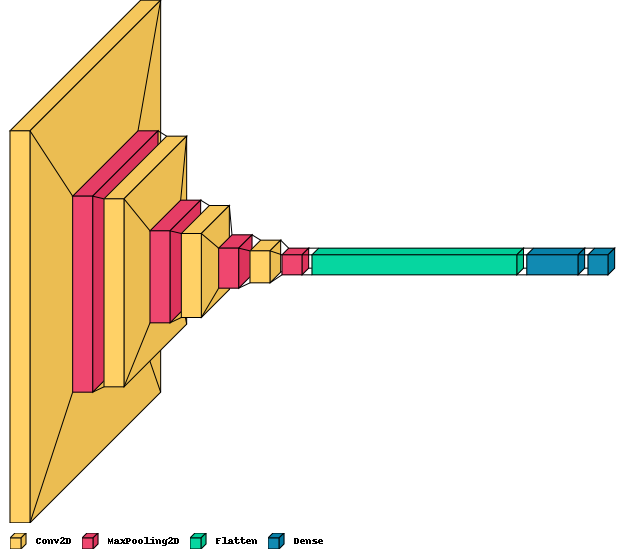

In [17]:
visualkeras.layered_view(model, legend=True)

Huấn luyện mô hình

In [13]:
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
)

model.save("/kaggle/working/M1.h5")

Epoch 1/200


I0000 00:00:1709626145.688540     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 [==============================] - 36s 326ms/step - loss: 1.0799 - accuracy: 0.3832 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0643 - val_accuracy: 0.3816 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/200
96/96 [==============================] - 19s 197ms/step - loss: 1.0322 - accuracy: 0.4630 - precision_1: 1.0000 - recall_1: 0.0036 - val_loss: 0.9975 - val_accuracy: 0.5303 - val_precision_1: 1.0000 - val_recall_1: 0.0237
Epoch 3/200
96/96 [==============================] - 19s 199ms/step - loss: 0.9657 - accuracy: 0.5179 - precision_1: 0.9901 - recall_1: 0.0661 - val_loss: 0.9234 - val_accuracy: 0.5382 - val_precision_1: 0.9732 - val_recall_1: 0.1434
Epoch 4/200
96/96 [==============================] - 19s 197ms/step - loss: 0.9011 - accuracy: 0.5426 - precision_1: 0.9443 - recall_1: 0.1282 - val_loss: 0.8588 - val_accuracy: 0.5947 - val_precision_1: 0.9412 - val_recall_1: 0.1684
Epoch 5/200
96/96 [==============================] - 19s 195

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hiển thị độ chính xác và giá trị lỗi của mô hình

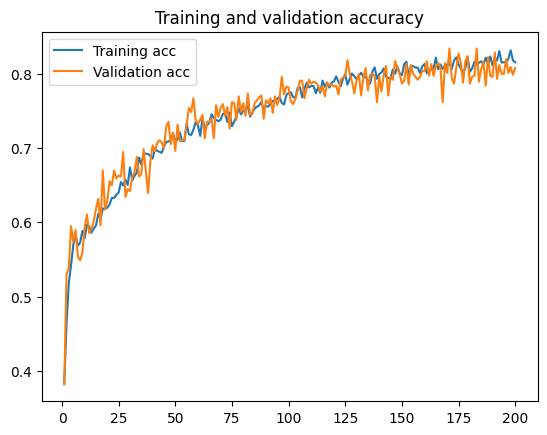

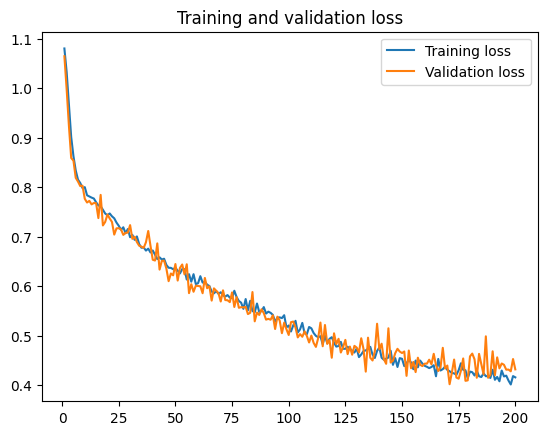

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Tính độ chính xác, giá trị lỗi và giá trị F1 của mô hình sau huấn luyện

In [21]:
test_loss, test_acc, test_pre, test_recall = model.evaluate(test_generator)
print(f"Accuracy: {test_acc}")
print(f"Loss: {test_loss}")
print(f"Precision: {test_pre}")
print(f"Recall: {test_recall}")

30/30 [==============================] - 2s 65ms/step - loss: 0.4069 - accuracy: 0.8400 - precision_1: 0.8443 - recall_1: 0.8105
Accuracy: 0.8399999737739563
Loss: 0.40686002373695374
Precision: 0.844298243522644
Recall: 0.8105263113975525


## Huấn luyện mô hình M2

Định nghĩa kiến trúc mô hình

In [6]:
import keras

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 512)       0

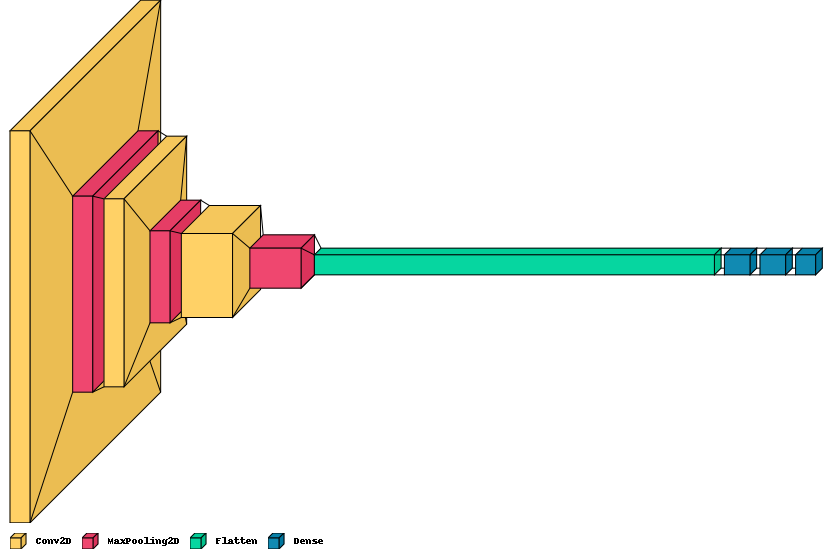

In [7]:
visualkeras.layered_view(model, legend=True)

Huấn luyện mô hình

In [8]:
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
)

model.save("/kaggle/working/M2.h5")

Epoch 1/200


I0000 00:00:1709646729.837929      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 [==============================] - 31s 262ms/step - loss: 1.0637 - accuracy: 0.4223 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0098 - val_accuracy: 0.5263 - val_precision: 1.0000 - val_recall: 0.0105
Epoch 2/200
96/96 [==============================] - 17s 179ms/step - loss: 0.9444 - accuracy: 0.5153 - precision: 0.9024 - recall: 0.0973 - val_loss: 0.8674 - val_accuracy: 0.5461 - val_precision: 0.9826 - val_recall: 0.1487
Epoch 3/200
96/96 [==============================] - 17s 177ms/step - loss: 0.8488 - accuracy: 0.5422 - precision: 0.6751 - recall: 0.2800 - val_loss: 0.8249 - val_accuracy: 0.5658 - val_precision: 0.7749 - val_recall: 0.2763
Epoch 4/200
96/96 [==============================] - 17s 177ms/step - loss: 0.8168 - accuracy: 0.5659 - precision: 0.7086 - recall: 0.3132 - val_loss: 0.8028 - val_accuracy: 0.5711 - val_precision: 0.7128 - val_recall: 0.3526
Epoch 5/200
96/96 [==============================] - 17s 175ms/step - loss: 0.8096 - accuracy: 0.568

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hiển thị độ chính xác và giá trị lỗi của mô hình

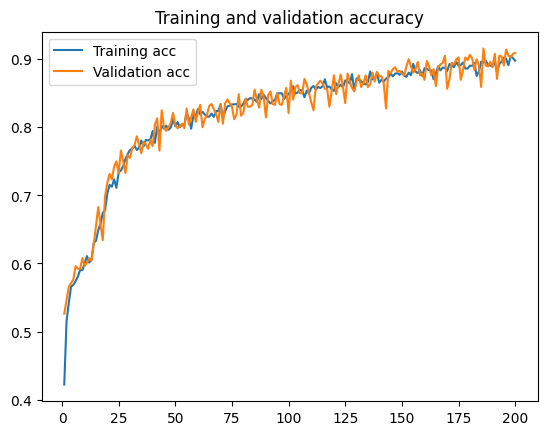

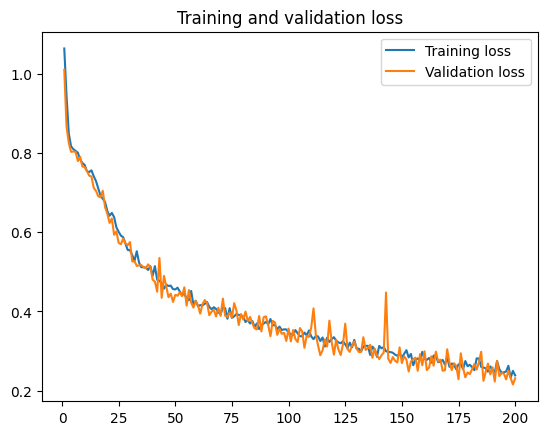

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Tính độ chính xác, giá trị lỗi và giá trị F1 của mô hình sau huấn luyện

In [11]:
test_loss, test_acc, test_pre, test_recall = model.evaluate(test_generator)
print(f"Accuracy: {test_acc}")
print(f"Loss: {test_loss}")
print(f"Precision: {test_pre}")
print(f"Recall: {test_recall}")

30/30 [==============================] - 2s 53ms/step - loss: 0.2934 - accuracy: 0.8968 - precision: 0.9037 - recall: 0.8895
Accuracy: 0.8968421220779419
Loss: 0.29340529441833496
Precision: 0.903743326663971
Recall: 0.8894736766815186


## Huấn luyện mô hình M3

Định nghĩa kiến trúc mô hình

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 128)       0         
 g2D)                                                 

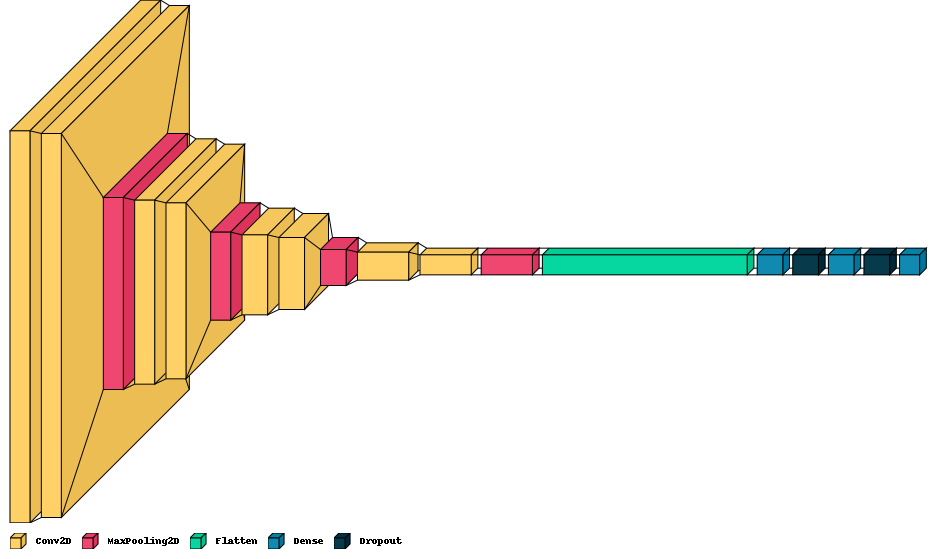

In [13]:
visualkeras.layered_view(model, legend=True)

Huấn luyện mô hình

In [14]:
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
)

model.save("/kaggle/working/M3.h5")

Epoch 1/200
96/96 [==============================] - 28s 198ms/step - loss: 1.0918 - accuracy: 0.3750 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0840 - val_accuracy: 0.3750 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/200
96/96 [==============================] - 17s 172ms/step - loss: 1.0295 - accuracy: 0.4522 - precision_1: 0.7717 - recall_1: 0.0322 - val_loss: 0.9373 - val_accuracy: 0.5039 - val_precision_1: 0.6197 - val_recall_1: 0.2487
Epoch 3/200
96/96 [==============================] - 16s 171ms/step - loss: 0.9112 - accuracy: 0.5163 - precision_1: 0.6496 - recall_1: 0.2425 - val_loss: 0.8693 - val_accuracy: 0.5671 - val_precision_1: 0.9433 - val_recall_1: 0.1750
Epoch 4/200
96/96 [==============================] - 16s 168ms/step - loss: 0.8671 - accuracy: 0.5288 - precision_1: 0.6588 - recall_1: 0.2754 - val_loss: 0.8631 - val_accuracy: 0.5276 - val_precision_1: 0.6831 - val_recall_1: 0.2553
Epoch 5/200
96/96 [=============================

Hiển thị độ chính xác và giá trị lỗi của mô hình

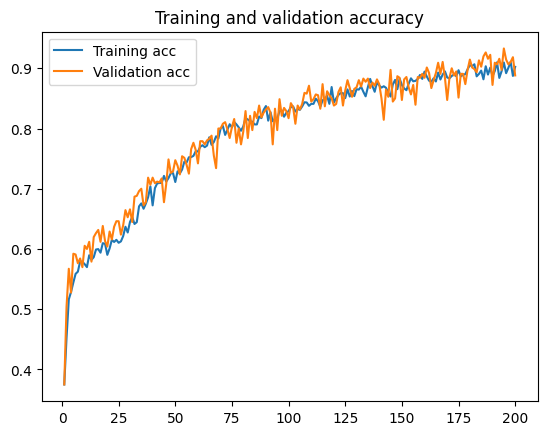

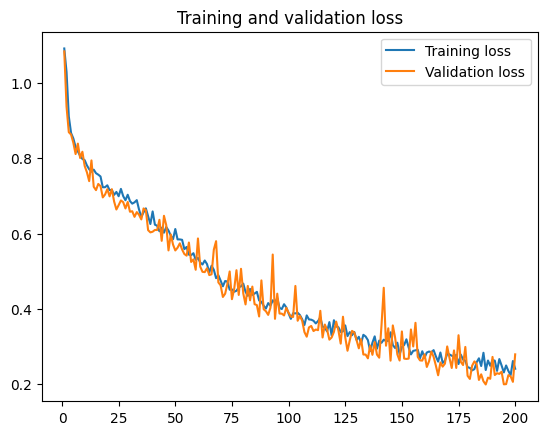

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Tính độ chính xác, giá trị lỗi và giá trị F1 của mô hình sau huấn luyện

In [16]:
test_loss, test_acc, test_pre, test_recall = model.evaluate(test_generator)
print(f"Accuracy: {test_acc}")
print(f"Loss: {test_loss}")
print(f"Precision: {test_pre}")
print(f"Recall: {test_recall}")

30/30 [==============================] - 4s 119ms/step - loss: 0.5034 - accuracy: 0.8684 - precision_1: 0.8708 - recall_1: 0.8653
Accuracy: 0.8684210777282715
Loss: 0.5034159421920776
Precision: 0.8707627058029175
Recall: 0.8652631640434265
